# Measuring density

Measuring density is a typical exercise in urban analytics. `momepy` allows to measure different types (see [API/Intensity](https://docs.momepy.org/en/latest/api.html#measuring-intensity)). However, some density characters are easy to measure thanks to the properties of the data model.

In [1]:
import matplotlib.pyplot as plt
import momepy
import osmnx as ox

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation layer.

In [3]:
point = (40.731603, -73.977857)
dist = 1000
gdf = ox.features.features_from_point(
    point, dist=dist, tags={"building": True}
)
gdf_projected = ox.projection.project_gdf(gdf)
buildings = gdf_projected[
    gdf_projected.geom_type.isin(["Polygon", "MultiPolygon"])
].reset_index(drop=True)

limit = momepy.buffered_limit(buildings)
tessellation = momepy.morphological_tessellation(
    buildings, clip=limit
).to_frame('geometry')

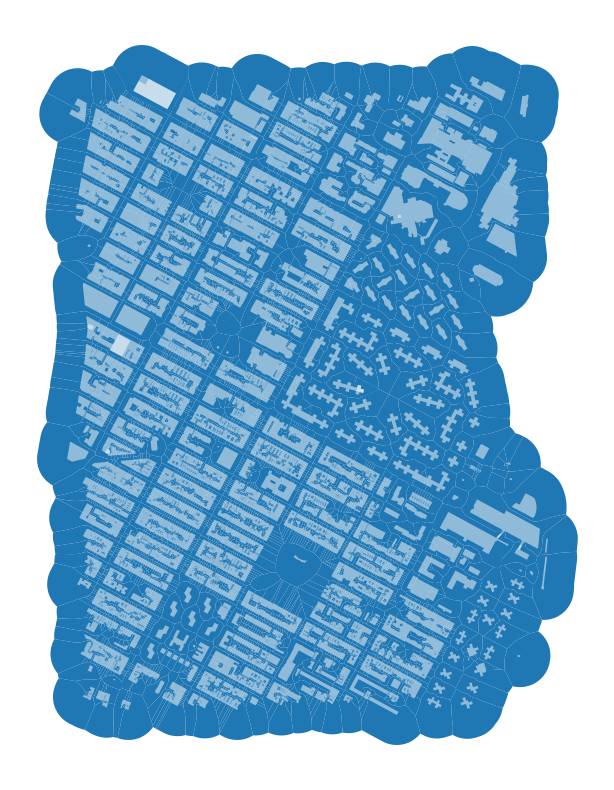

In [4]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax)
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()
plt.show()

We have some edge effect here as we are using the buffer as a limit for tessellation in the middle of the urban fabric, but for these examples, we can work with it anyway. Keep in mind that values on the edge of this area will be skewed.

## Covered Area Ratio

Covered area ratio, in our case measured on tessellation cells, is a simple ratio of the area of buildings divided by area of cells. Thanks to the matching index, this is easy:

In [5]:
tessellation["CAR"] = buildings.area / tessellation.area

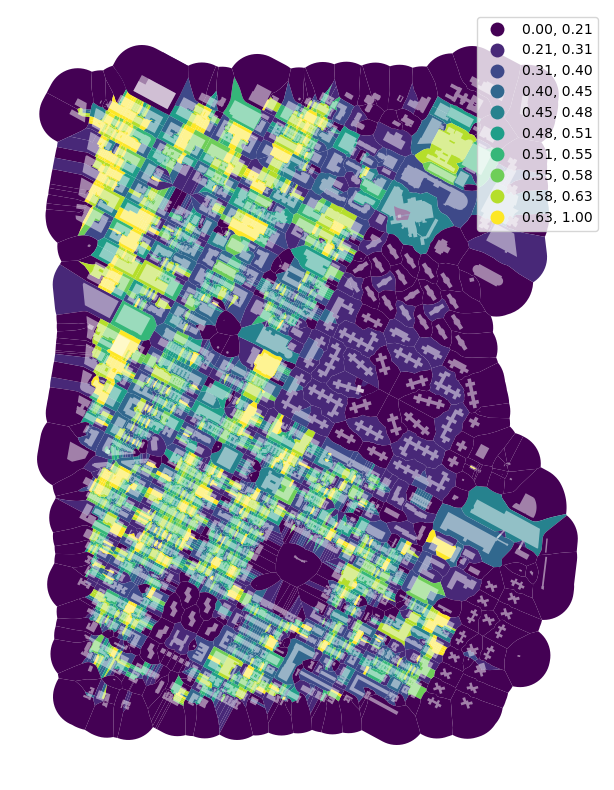

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(
    ax=ax, column="CAR", legend=True, scheme="quantiles", k=10, cmap="viridis"
)
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()
plt.show()

## Floor Area Ratio

Because we know building heights for our `buildings` gdf, we can also calculate FAR. This part of New York has height data, only stored as strings, so we have to convert them to `floats` (or `int`) and fill `NaN` values with zero.

FAR requires floor areas for building gdf instead of covered area. From the height, you can estimate a number of floors given 1 floor equals 3 meters of height.

In [8]:
def clean_heights(x):
    try:
        return float(x)
    except ValueError:
        return 0


buildings["height"] = buildings["height"].fillna(0).apply(clean_heights)
buildings["floors"] = buildings["height"] // 3

buildings["floor_area"] = buildings.area * buildings["floors"]

In [9]:
tessellation["FAR"] =  buildings["floor_area"] / tessellation.area

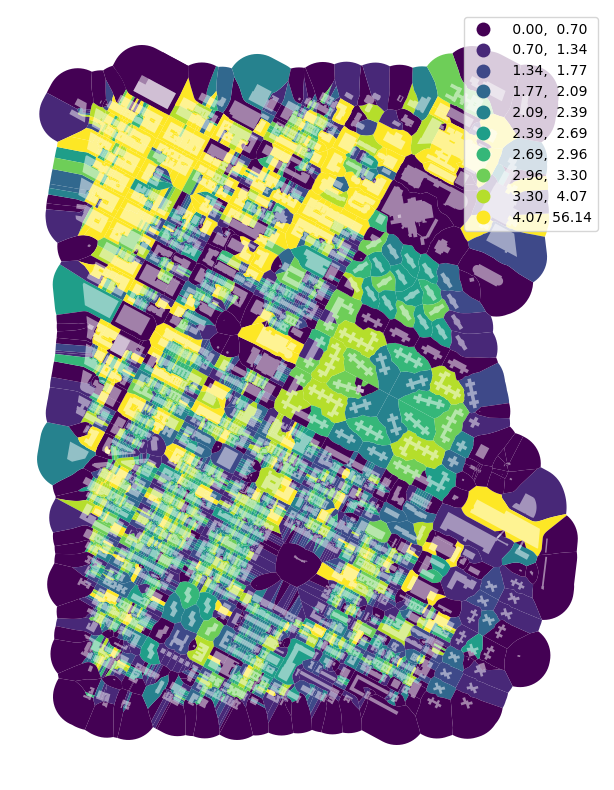

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(
    ax=ax, column="FAR", legend=True, scheme="quantiles", k=10, cmap="viridis"
)
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()
plt.show()

Location-based density is described in [examples using spatial weights](../weights/examples.ipynb).